# **The Mauna Loa $\text{CO}_2$ Concentration**

n 1958, Charles David Keeling (1928-2005) from the Scripps Institution of Oceanography began recording carbon dioxide ($\text{CO}_2$) concentrations in the atmosphere at an observatory located at about 3,400 m altitude on the Mauna Loa Volcano on Hawaii Island. The location was chosen because it is not influenced by changing $\text{CO}_2$ levels due to the local vegetation and because prevailing wind patterns on this tropical island tend to bring well-mixed air to the site. While the recordings are made near a volcano (which tends to produce $\text{CO}_2$), wind patterns tend to blow the volcanic $\text{CO}_2$ away from the recording site. Air samples are taken several times a day, and concentrations have been observed using the same measuring method for over 60 years. In addition, samples are stored in flasks and periodically reanalyzed for calibration purposes. The observational study is now run by Ralph Keeling, Charles's son. The result is a data set with very few interruptions and very few inhomogeneities. It has been called the “most important data set in modern climate research."

The dataset used in this notebook provides the concentration of $\text{CO}_2$ recorded at Mauna Loa for each month starting March 1958. More description is provided in the dataset file. I will be considering only the $\text{CO}_2$ concentration given in **column 5**. The goal is to fit the data and understand its variations.

Let $C_i$ be the average $\text{CO}_2$ concentration in month $i$ ($i=1,2,...$, counting from March 1958), the the time-series will be described as,
$$
C_i=F(t_i)+P(t_i)+R_i
$$
where
* $F:t \mapsto F(t)$ accounts for the long-term trend
* $t_i$ is time at the **middle of the $i$-th month**, measured in **fractions of years** after Jan 15, 1958; specifically, 
$$t_ i=\frac{i+0.5}{12}, \qquad i=0,1,\dots$$
where $i=0$ corresponds to Jan, 1958, adding $0.5$ is because the first measurement is halfway through the first month.
* $P(t_i)$ is periodic in $t$ with a fixed period, accounting for the seasonal pattern.
* $R_i$ is the remaining residual that accounts for all other influences.

The decomposition is meaningful only if the range of $F$ is much larger than the amplitude of the $P$ and this amplitude in turn is substantially larger than that of $R_i$.

## **Import package dependencies**

In [1]:
import pandas as pd

import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split


from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 144
rcParams["figure.figsize"] = (12,8)
plt.style.use('ggplot')

## **Import Data**

In [2]:
CO2_URL = "https://raw.githubusercontent.com/adamgogacz/time-series-processing/main/Data/CO2.csv"
skiprows = [*range(54),55,56]
co2_df = pd.read_csv(CO2_URL,skiprows=skiprows)

## **Pre-processing Data**

There are some inhomogeneities in data and the $\text{CO}_2$ concentration at these points is recorded as -99.99. These values will be fowrard-filled whenever possible

In [3]:
def get_valid(ts,i):
  if len(ts) - 1 == i:
    # if last entry is invalid
    _idx_valid = np.argwhere(ts[:,0] >= 0)
    return ts[_idx_valid[-1]]
  elif 0 == i:
    # if the first entry is invalid 
    # at this point all following entries 
    # have been fixed
    return ts[i+1]
  else:
    # interior cases
    if ts[i-1] > 0:
      return ts[i-1]
    else:
      return get_valid(ts,i+1)

co2 = (co2_df.iloc[:,4].to_numpy()).reshape(-1,1)
year = (co2_df.iloc[:,0].to_numpy()).reshape(-1,1)
month = (co2_df.iloc[:,1].to_numpy()).reshape(-1,1)
t = (year - np.min(year)) + (month - 0.5)/12

idx_ = np.argwhere(co2[:,0] < 0)
for i in np.flip(idx_):
  co2[i] = get_valid(co2,i)

### **Split Data into Train and Test Subsets**

In [4]:
t_train, t_test, co2_train, co2_test = train_test_split(t, co2, test_size=0.2, 
                                                    shuffle=False)
month_train, month_test, year_train, year_test = train_test_split(month, year,
                                                  test_size=0.2, shuffle=False)

### Fitting a Linear Model

Fitting the training data to a simple linear model $F_1(t)\sim \alpha_0+\alpha_1 t$.

Linear regression intercept: 309.19276544960064
Linear regression coefficient: 1.4013460896256
Mean squared error (RMSE) regression loss: 10.803458099378009
Mean absolute percentage error (MAPE) regression loss: 2.493553608846381


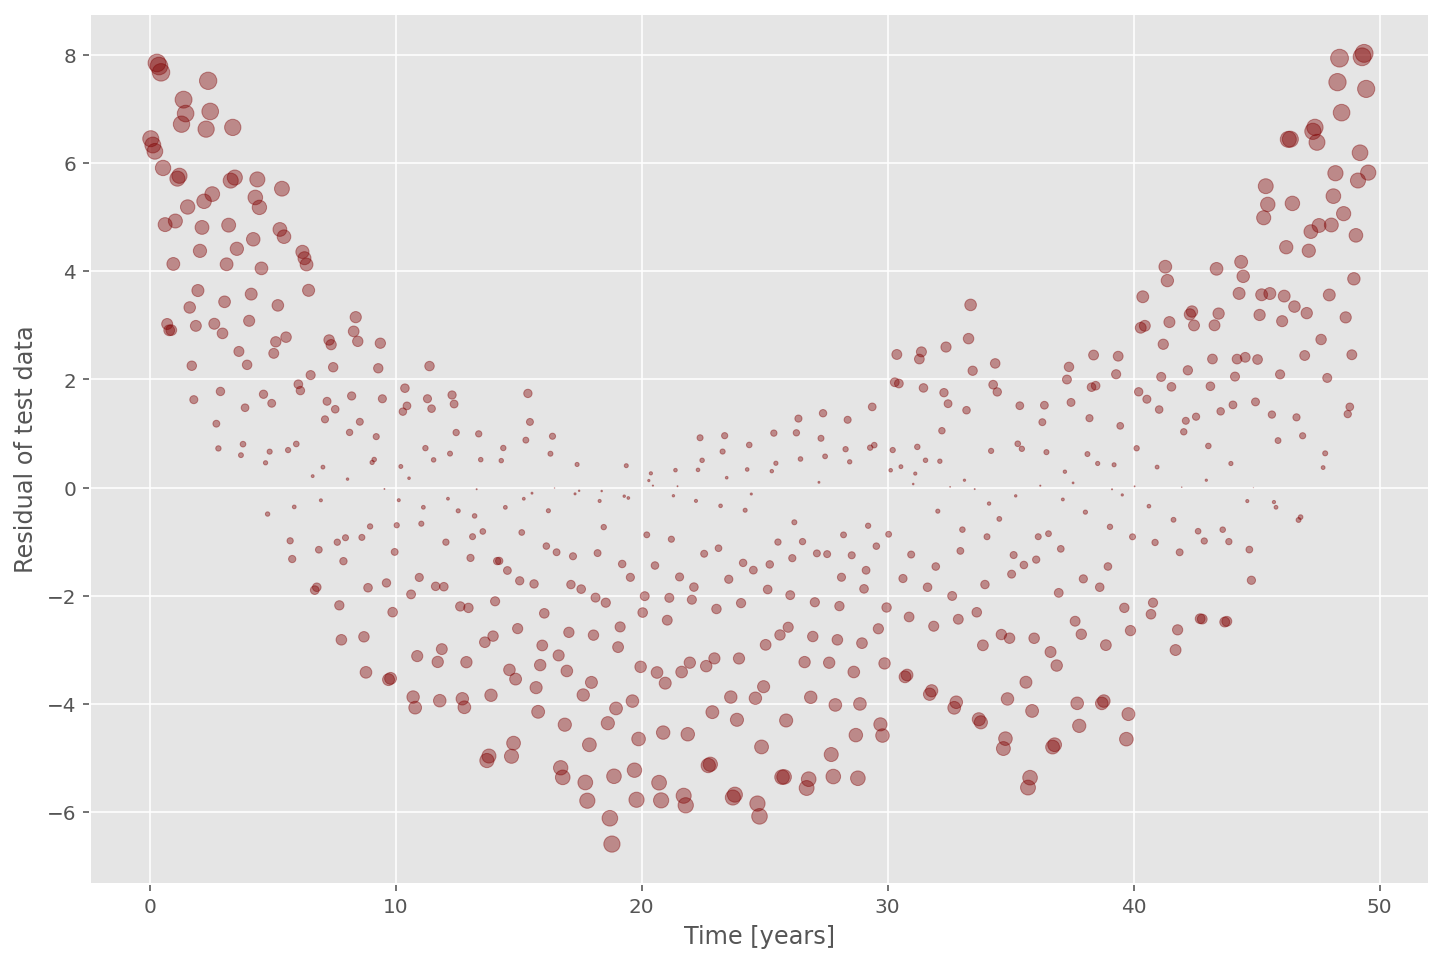

In [5]:
reg = LinearRegression().fit(t_train,co2_train)
co2_train_pred = reg.predict(t_train)
co2_test_pred = reg.predict(t_test)
plt.scatter(t_train,co2_train-co2_train_pred,s=10*np.abs(co2_train-co2_train_pred),alpha=0.4,c='maroon')
plt.xlabel('Time [years]')
plt.ylabel('Residual of test data')
plt.grid(visible=True)
print(f'Linear regression intercept: {reg.intercept_[0]}')
print(f'Linear regression coefficient: {reg.coef_[0,0]}')
print(f'Mean squared error (RMSE) regression loss: {mean_squared_error(co2_test,co2_test_pred,squared=False)}')
print(f'Mean absolute percentage error (MAPE) regression loss: {100*mean_absolute_percentage_error(co2_test,co2_test_pred)}')

### **Fitting a Quadratic Model**

Fitting a quadratic model,
$$F_2(t) \sim \beta _0 + \beta _1 t + \beta _2 t^2$$
to the data, compute $\text {RMSE}$ and $\text {MAPE}$, and evaluate which of these models is the lowest degree model that still best captures the trend of the data.

Quadratic regression intercept: 314.21857728771073
Quadratic regression coefficients: [0.79318148 0.0122655 ]
Mean squared error (RMSE) regression loss: 2.4658731686268505
Mean absolute percentage error (MAPE) regression loss: 0.525801105147915


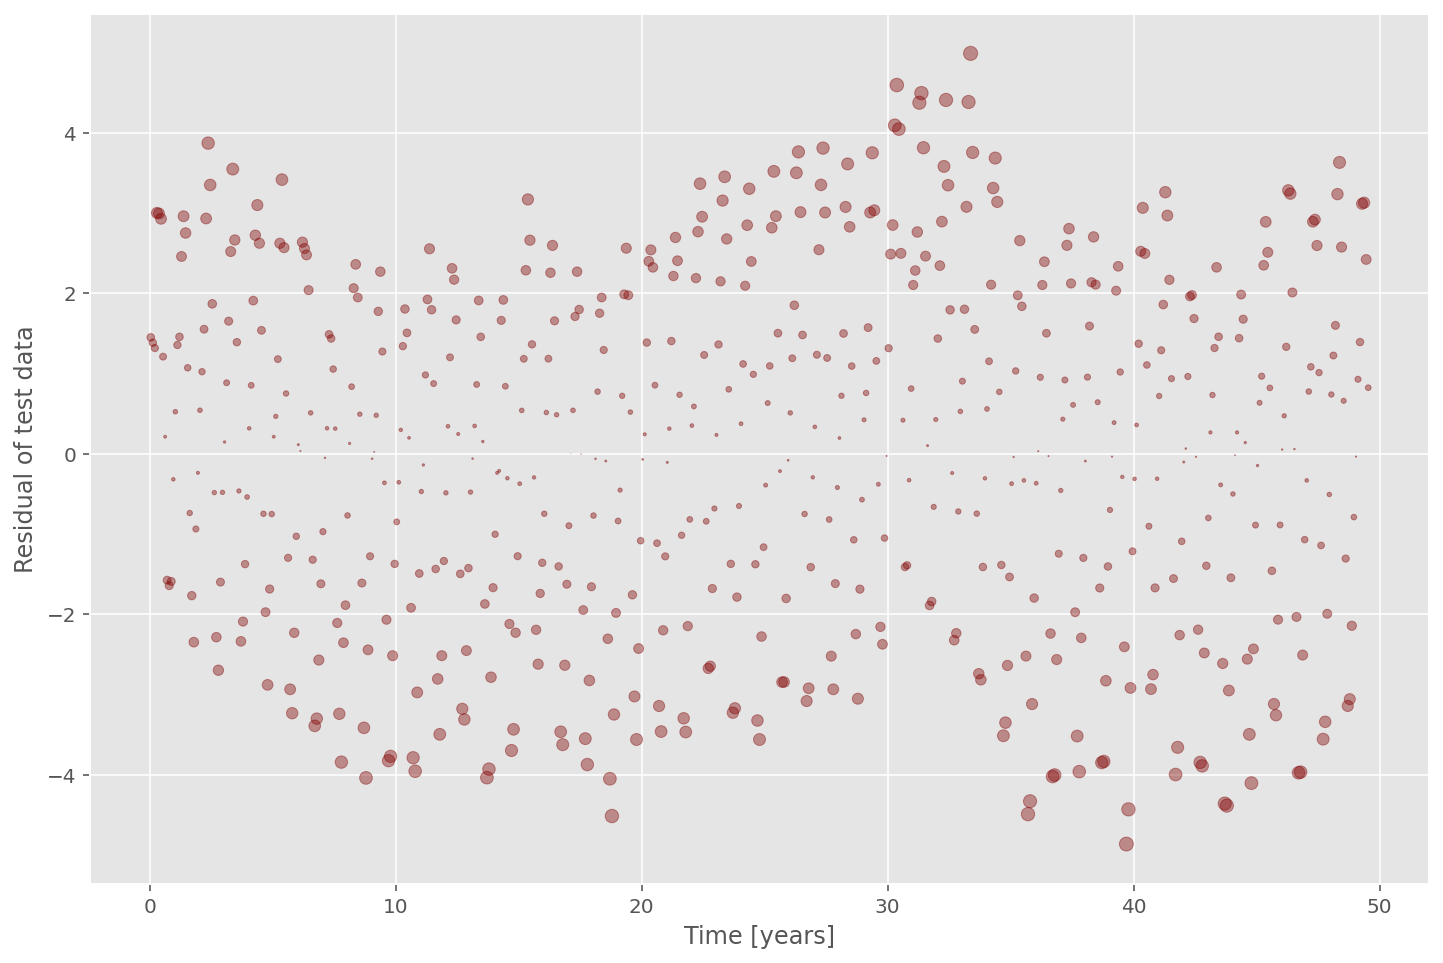

In [6]:
t_train_quad = np.hstack((t_train,t_train**2))
t_test_quad = np.hstack((t_test,t_test**2))
reg_quad = LinearRegression().fit(t_train_quad,co2_train)
co2_train_quad_pred = reg_quad.predict(t_train_quad)
co2_test_quad_pred = reg_quad.predict(t_test_quad)
plt.scatter(t_train,co2_train-co2_train_quad_pred,s=10*np.abs(co2_train-co2_train_quad_pred),alpha=0.4,c='maroon')
plt.xlabel('Time [years]')
plt.ylabel('Residual of test data')
plt.grid(visible=True)
print(f'Quadratic regression intercept: {reg_quad.intercept_[0]}')
print(f'Quadratic regression coefficients: {reg_quad.coef_.flatten()}')
print(f'Mean squared error (RMSE) regression loss: {mean_squared_error(co2_test,co2_test_quad_pred,squared=False)}')
print(f'Mean absolute percentage error (MAPE) regression loss: {100*mean_absolute_percentage_error(co2_test,co2_test_quad_pred)}')

### **Fitting a Cubic Model**

Fitting a cubic model,
$$F_3(t) \sim \gamma_0 + \gamma_1 t + \gamma_2 t^2 + \gamma_3 t^3$$
to the data, compute $\text {RMSE}$ and $\text {MAPE}$, and evaluate which of these models is the lowest degree model that still best captures the trend of the data.

Cubic regression intercept: 314.9388134281101
Cubic regression coefficients: [ 6.18873668e-01  2.10541195e-02 -1.18166250e-04]
Mean squared error (RMSE) regression loss: 4.077060290037374
Mean absolute percentage error (MAPE) regression loss: 0.8351476557212393


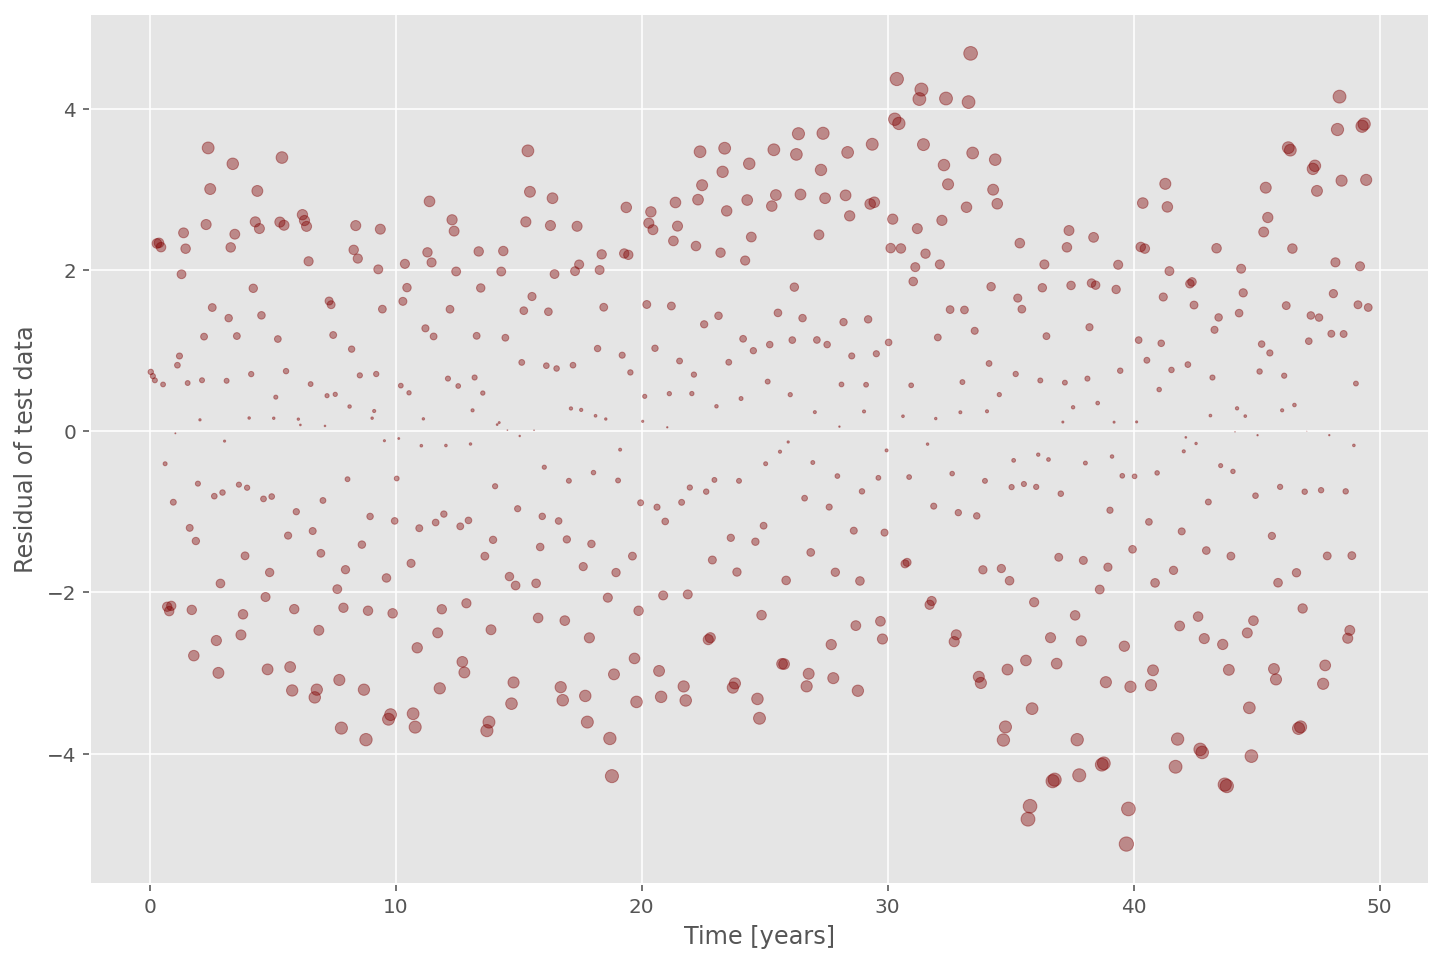

In [7]:
t_train_cubic = np.hstack((t_train,t_train**2,t_train**3))
t_test_cubic = np.hstack((t_test,t_test**2,t_test**3))
reg_cubic = LinearRegression().fit(t_train_cubic,co2_train)
co2_train_cubic_pred = reg_cubic.predict(t_train_cubic)
co2_test_cubic_pred = reg_cubic.predict(t_test_cubic)
plt.scatter(t_train,co2_train-co2_train_cubic_pred,s=10*np.abs(co2_train-co2_train_cubic_pred),alpha=0.4,c='maroon')
plt.xlabel('Time [years]')
plt.ylabel('Residual of test data')
plt.grid(visible=True)
print(f'Cubic regression intercept: {reg_cubic.intercept_[0]}')
print(f'Cubic regression coefficients: {reg_cubic.coef_.flatten()}')
print(f'Mean squared error (RMSE) regression loss: {mean_squared_error(co2_test,co2_test_cubic_pred,squared=False)}')
print(f'Mean absolute percentage error (MAPE) regression loss: {100*mean_absolute_percentage_error(co2_test,co2_test_cubic_pred)}')

### **Fitting a Periodic Signal**

Let $F_n(t)$ be the polynomial to sufficiently represent the trend in the data, the next and final step will be to capture the periodicity/seasonality of the data.

First, the deterministic trend $F_n(t)$ will be removed and the residual $P_i := C_i-F_n(t_i)$ will be approximated as a sinusoid,
$$
P_i = \mu_R + A_R \cos\big(2\pi f_R t_i + \phi_R \big)
$$
where the all parameters are obtained from the `FFT` of the residual.

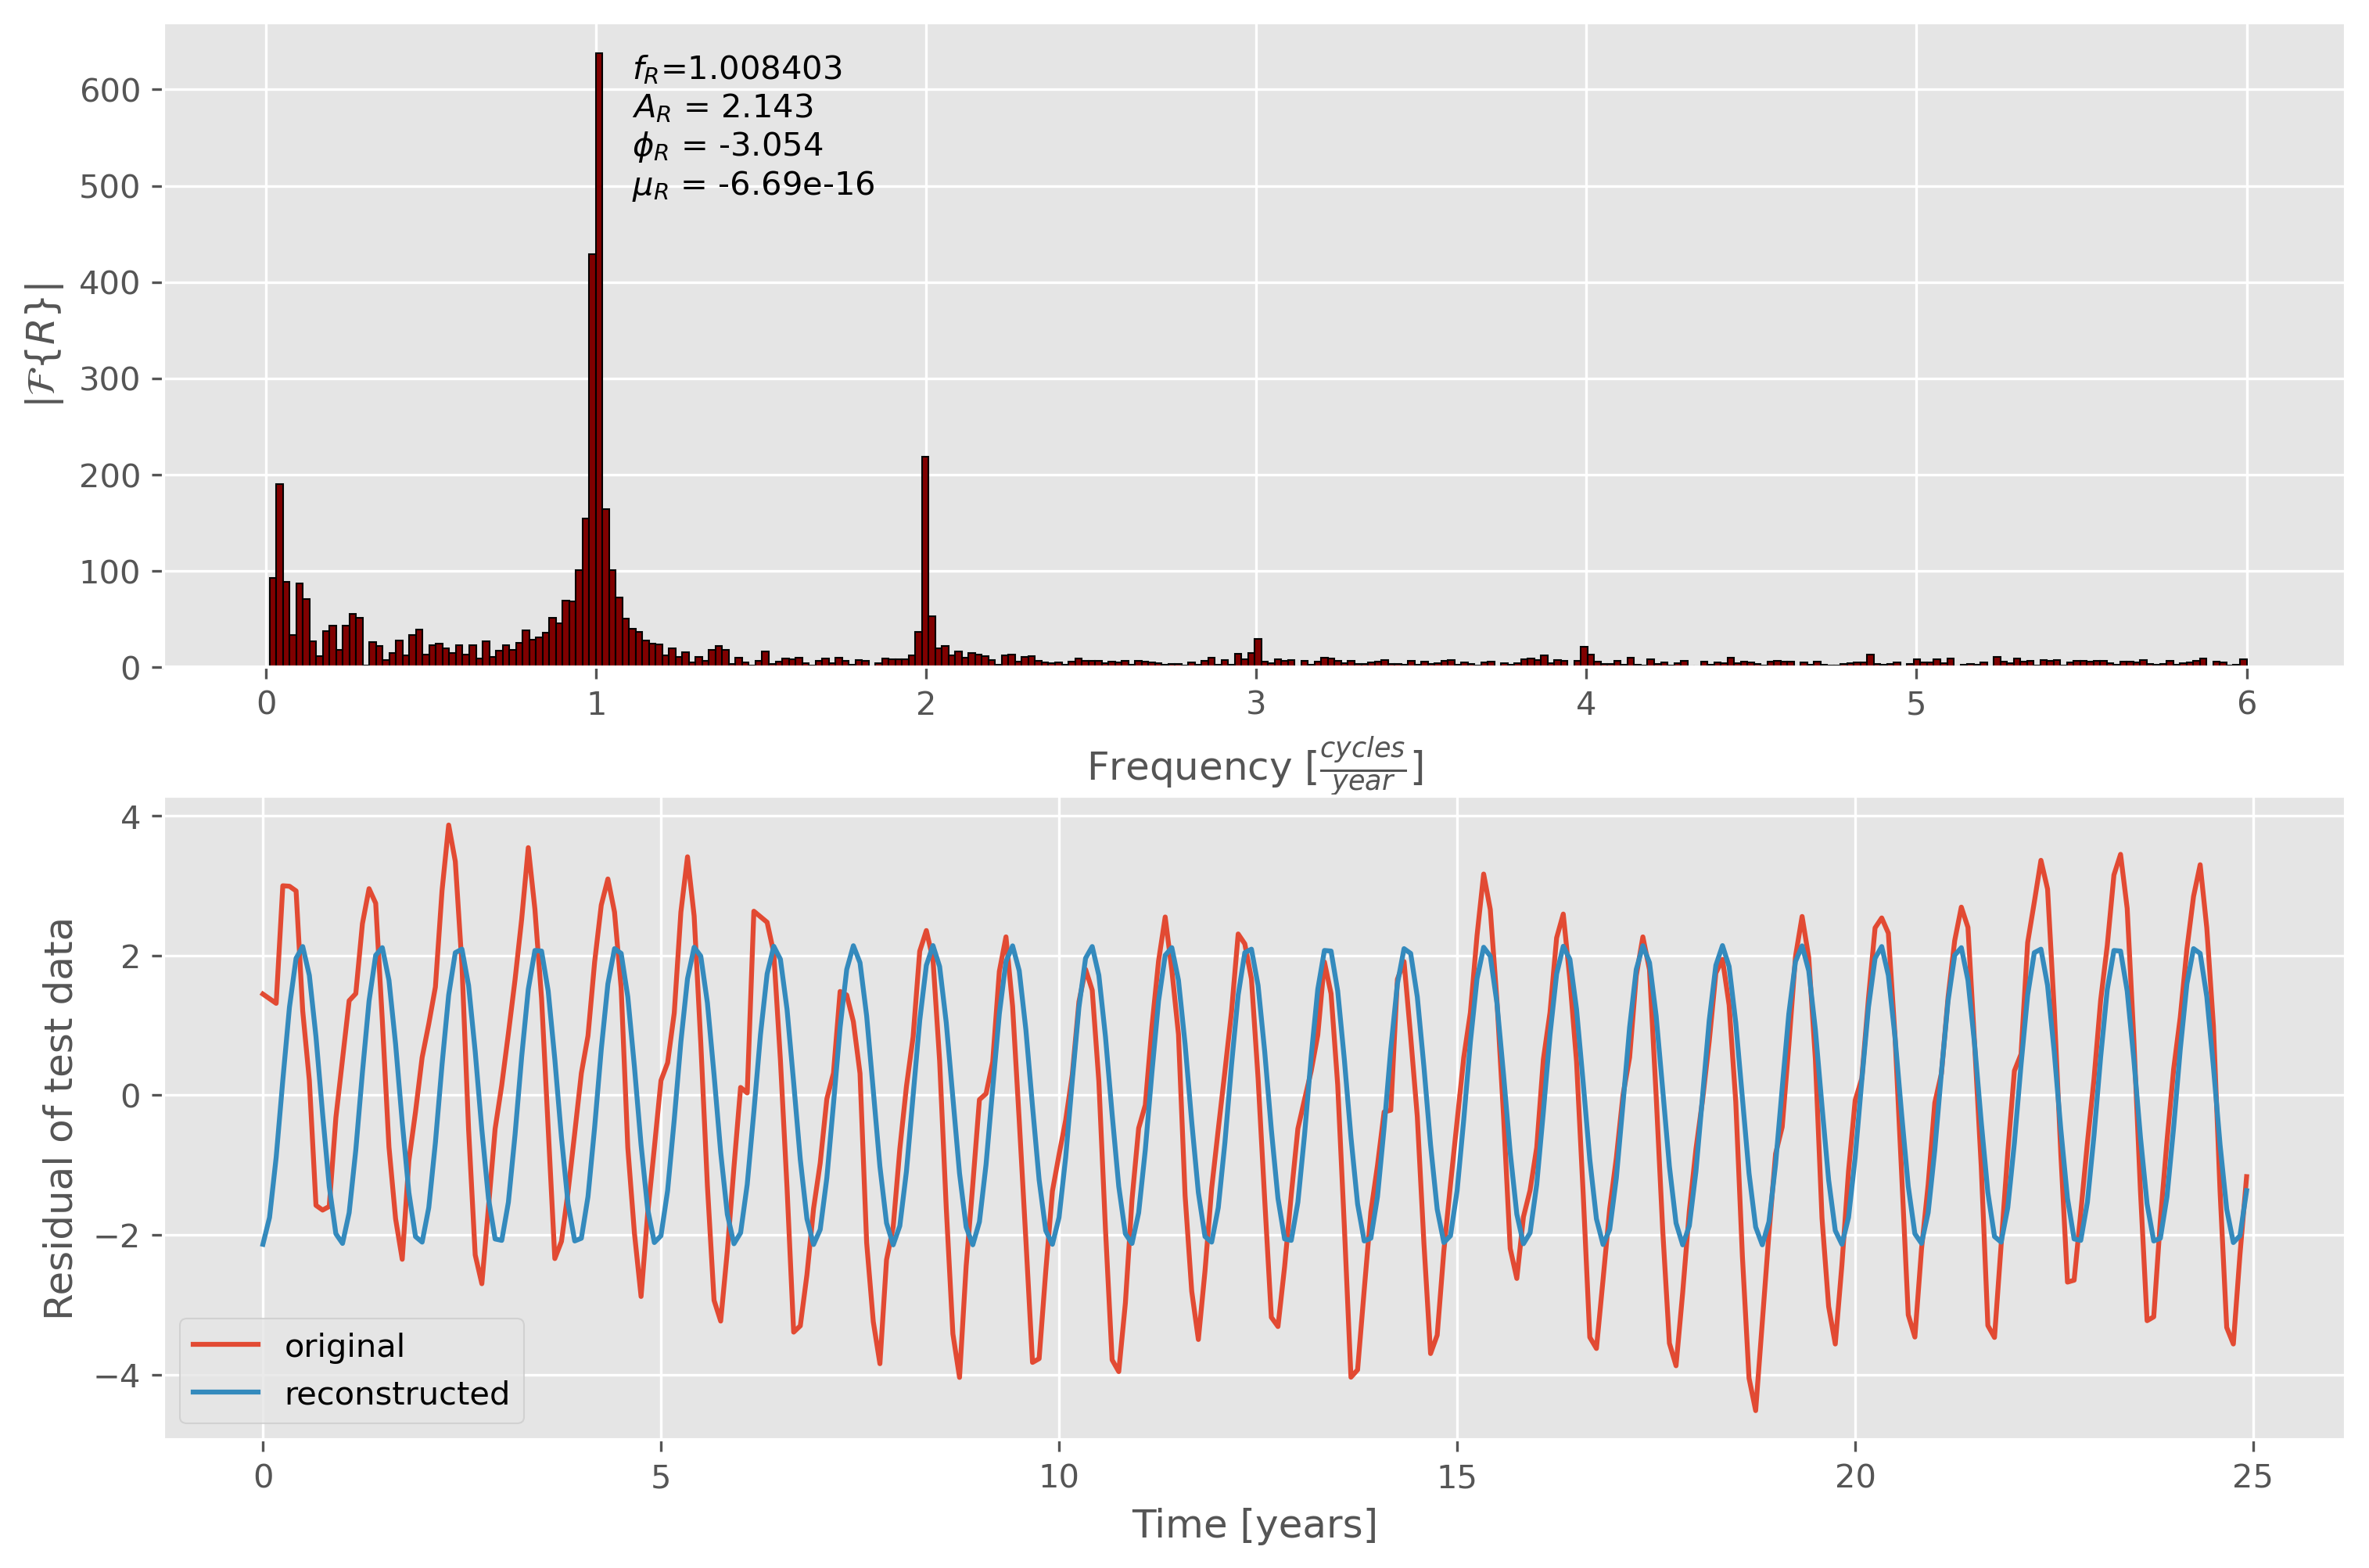

In [8]:
R_train = co2_train - co2_train_quad_pred
# R_train = np.concatenate((R_train[:,0],np.zeros(10000))).reshape(-1,1)
# R_train = 400 + 637.436*np.cos(2*np.pi*2.0168067226890756*_t - 1.543)

# _t = t_train - t_train.min()
_t = (1/12)*np.arange(0,R_train.size)
mu_R = R_train.mean()
R_train = R_train - mu_R

# get frequency domain signal
FFT_R_train = np.fft.rfft(R_train[:,0])
freq = np.fft.rfftfreq(R_train.size, d=1/12)
Amp_FFT_R_train = np.abs(FFT_R_train)

# find peak frequency and reconstruct the sinusoid
imax = np.nonzero(Amp_FFT_R_train == Amp_FFT_R_train.max())[0]
f_R, A_R = freq[imax][0], 2*Amp_FFT_R_train[imax][0]/R_train.size
phi_R  = np.angle(FFT_R_train[imax])[0]

P_i_recon = A_R*np.cos(2*np.pi*f_R*_t + phi_R)


fig, ax = plt.subplots(2,figsize=(12,8),dpi=300)
ax[0].bar(x=freq,height=Amp_FFT_R_train,width=freq[1],label='FFT',color='maroon',edgecolor='black')
ax[0].annotate(text=rf"$f_R$={f_R:.6f}" + "\n" 
            + rf"$A_R$ = {A_R:.3f}" + "\n"
            + rf"$\phi_R$ = {phi_R:.3f}" + "\n"
            + rf"$\mu_R$ = {mu_R:.3g}" ,
            xy=(freq[imax]+0.1,Amp_FFT_R_train[imax]),
            verticalalignment='top', horizontalalignment='left')
ax[0].set_xlabel(r'Frequency [$\frac{cycles}{year}$]')
ax[0].set_ylabel(r'$|\mathcal{F}\{R\}|$')
ax[0].grid(visible=True)

_idxd=np.full(_t.shape,False,dtype=bool)
_idxd[0:300] = True
ax[1].plot(_t[_idxd],R_train[_idxd],label='original')
ax[1].plot(_t[_idxd],P_i_recon[_idxd],label='reconstructed')
ax[1].set_xlabel('Time [years]')
ax[1].set_ylabel('Residual of test data')
ax[1].legend()


# del freq, FFT_R_train, fig, ax, P_i_recon, _t, _idxd